#Zero-th Order Frank Wolfe methods for adversarial attacks
Authors:
- Jacopo Magliani 2040912
- Stefano Minto 2062885

In [1]:
#import libraries
import numpy as np
import math
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from numpy import asarray
from keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
import os
import matplotlib.pyplot as plt
import time
import random

In [7]:
#Function to obtain a vector of length "dim" such that the sum of the squared elements is equal to "norm"
def sample_vector_with_norm(dim, norm):
    u = np.random.normal(size=dim)  # Generate a vector from a standard normal distribution
    u /= np.linalg.norm(u)  # Normalize the vector to have a unit length
    u *= norm  # Scale the vector to the desired norm
    return u

# Frank Wolfe Black Box

In [3]:
#Function to obtain the estimate of the gradient of the the given input "x" (matrix, pixels of the image) and (incorrect) label "y_tar"
#"d" is the number of dimensions, it is 28 for a matrix "x" 28x28
#"b" and "sigma" are parameters to scale the result
#"opt" refers to (opt=1) sample "u" uniformly from the euclidean unit sphere with "norm"=1 or (opt=2) from the standard Gaussian distribution
#"rgb" refers to (rgb=1) a rgb image

#Original algorithm uses a for cycle and for each iteration samples a vector "u" to change the original "x", compute the loss function and sums the
#obtained "q" to the previous output.
#Instead, to speed up the computation we obtain "b" different vectors "u" and in parallel we compute the operations, then we sum the results

def GRAD_EST(x,b,d,sigma,y_tar,opt,rgb):
    if(opt==1):
        u=[]
        for i in range(b): #create "b" vectors "u"
            u2=sample_vector_with_norm(d**2,1)
            u2=u2.reshape(d,d)
            if(rgb==1):#if rgb replicate each rgb pixel
              u2=np.repeat(u2[:, :, np.newaxis], 3, axis=2)
            u.append(u2)
        if(rgb==1):
          mats=np.tile(x, (b, 1, 1, 1))
        else:
          mats=np.tile(x, (b, 1, 1)) #replicate "b" times both the original "x" and "y_tar" to allow parallel operations
        lab=np.tile(y_tar, (b, 1))
        pred1=model(mats+np.multiply(u,sigma))#obtain the predictions for each matrix
        pred2=model(mats-np.multiply(u,sigma))
        res=-np.sum(lab * np.log(pred1), axis=1)+np.sum(lab * np.log(pred2), axis=1) #obtain the loss for each matrix
        res=(res*d**2)/(2*b*sigma) #rescale
        if(rgb==1):
          res = np.repeat(res, 3)
          res = res.reshape(-1, 3)
        res=u*res[:, np.newaxis, np.newaxis] #multiply the result of each matrix for its corresponding "u"
        return np.sum(res,axis=0) #sum the results of all matrices
    else:
        u=[]
        for i in range(b):
            u2=np.random.randn(d**2)
            u2=u2.reshape(d,d)
            if(rgb==1):
              u2=np.repeat(u2[:, :, np.newaxis], 3, axis=2)
            u.append(u2)
        if(rgb==1):
          mats=np.tile(x, (b, 1, 1, 1))
        else:
          mats=np.tile(x, (b, 1, 1))
        lab=np.tile(y_tar, (b, 1))
        pred1=model(mats+np.multiply(u,sigma))
        pred2=model(mats-np.multiply(u,sigma))
        res=-np.sum(lab * np.log(pred1), axis=1)+np.sum(lab * np.log(pred2), axis=1)
        res=res/(2*b*sigma)
        if(rgb==1):
          res = np.repeat(res, 3)
          res = res.reshape(-1, 3)
        res=u*res[:, np.newaxis, np.newaxis]
        return np.sum(res,axis=0)


In [4]:
#Function to obtain the modified matrix of the original "x_ori" given its target wrong label "y_tar"
#"T" is the number of iterations, at each iteration performs the estimate of the gradient to update "x", in the end return the modified "x"
#"d","b","sigma","opt" are the same parameters "GRAD_EST" receives in input
#y_step are the steps size
def frank_wolfe_bb(x_ori, y_tar,d, T,epsilon, y_step, b, sigma,beta,opt,rgb):
    x = x_ori.copy() #copy the original to avoid errors
    m = GRAD_EST(x, b,d, sigma, y_tar , opt,rgb)
    changes=[] #instead of returns just the last "x" at each iteration append the obtained "x" so far. This is used for later graphical plots purposes

    for t in range(1,T+1): #it must start with 1 and not 0 since later y_step/math.sqrt(t)
        q = GRAD_EST(x, b,d ,sigma,y_tar,opt,rgb)
        m = beta * m + (1 - beta) * q
        x = x - y_step/math.sqrt(t) * epsilon * np.sign(m) - y_step/math.sqrt(t) * (x - x_ori)
        changes.append(x)

    return changes #the ultimate "x" would be the last of the list

# Acc-FWBB

In [5]:
#Functions to obtain the estimate of the gradient of the given matrix "x" and label "y_tar"

#The original algorithm draws "b_length" i.i.d vectors "u" from uniform distribution over unit sphere, then peforms the mean of the
#estimates of the gradients
#Here we receive the original "x", the label "y_tar" and the "b_length" vectors "u"
#As for GRAD_EST we replicate "x" and "y_tar" for "b_length" times to allow parallel computation for each "u"
#"d" is the number of dimensions, it is 28 for a matrix "x" 28x28
#"beta" is a smoothing parameter
def unige(x,y_tar,d,b_length,beta,u,rgb):
    if(rgb==1):
      mats=np.tile(x, (b_length, 1, 1, 1))
    else:
      mats=np.tile(x, (b_length, 1, 1))
    lab=np.tile(y_tar, (b_length, 1))
    pred1=model(mats+np.multiply(u,beta))#prediction using the modified "x"
    pred2=model(mats) #predictions using the original "x"
    res=-np.sum(lab * np.log(pred1), axis=1)+np.sum(lab * np.log(pred2), axis=1)
    res=res*d**2/beta
    if(rgb==1):
      res = np.repeat(res, 3)
      res = res.reshape(-1, 3)
    res=u*res[:, np.newaxis, np.newaxis]
    return np.sum(res,axis=0)

#The original algorithm peforms "d" sums, where "mi" is a coordinate-wise smoothing parameter and "e" is a basis vector with 1 at its j-th coordinate
#and 0 otherwhise
#Instead of doing a for cycle again we use parallel computation
def cooge(x,y_tar, d,mi,indexes,rgb):
    if(rgb==1):
      first=np.tile(x, (d**2, 1, 1,1))
      zer=np.zeros((d**2, d, d,3))
    else:
      first=np.tile(x, (d**2, 1, 1))#copy the original matrix "x" and the label "y_tar" d*d times
      zer=np.zeros((d**2, d, d))#create 784 matrices of 0
    second=first.copy()
    lab=np.tile(y_tar, (d**2, 1))
    if(len(indexes)==d**2): #if we have 784 indices iteratively add 1*"mi" in the correct position of the right matrix e.g. ind=1 -> [mat=1,row=0,col=1]
        for i in range(d):
            for j in range(d):
                index = i * d + j
                zer[index, i, j] = mi
    else:#otherwise put 1*"mi" only in the given positions
        for ind in indexes:
            zer[ind,ind//d,ind%d] = mi
    first = first+zer
    second= second-zer
    pred1=model(first)
    pred2=model(second)
    res=(-np.sum(lab * np.log(pred1), axis=1)+np.sum(lab * np.log(pred2), axis=1))/(2*mi)
    if(rgb==1):
      res = np.repeat(res, 3)
      res = res.reshape(-1, 3)
    res=zer*res[:, np.newaxis, np.newaxis]
    return np.sum(res,axis=0)

In [6]:
#Function to implement Acc-SZOFW algorithm
#"x_ori" is the original matrix "d"x"d", "y_tar" is the incorrect target label
#"T" is the number of iterations, "q" is used to switch between the possible computations
#"n" is used for the finite sum setting and mod(t,q)=0, for Single Adversarial Perturbation it is fixed to 1
#"mi" is used for Cooge, "beta" for Unige
# "b1" for the stochastic setting and mod(t,q)=0 for both Cooge and Unige , "b2" when mod(t,q)!=0
#"fs_setting" refers to use the finite sum setting (1), "setting2" refers to use Cooge (1) or Unige (2) in the stochastic setting

def acc_szofw(x_ori,y_tar,d, T,epsilon,q,b,b1,b2, n, mi,eta,beta, fs_setting, setting2,rgb):
    changes=[]
    x = x_ori.copy()
    y = x_ori.copy()
    z = x_ori.copy()
    z_list=[]#again instead of return just the last result we memorize all the results at each iteration
    v=np.zeros(d**2)
    v=v.reshape(d,d)
    res=np.zeros(d**2)
    res=res.reshape(d,d)
    if(rgb==1):
      v=np.repeat(v[:, :, np.newaxis], 3, axis=2)
      res=np.repeat(res[:, :, np.newaxis], 3, axis=2)

    for t in range(0,T):
        if(t%q==0): #if mod(t,q)=0
            if(fs_setting==1):#if finite sum setting use complete Cooge with 784 indexes
                indexes=np.arange(0,d**2)
                v = cooge(z,y_tar, d,mi,indexes,rgb)/n
            else:#if stochastic setting
                if(setting2==1):#use Cooge with b1 random features
                    indexes=random.sample(range(d**2), b1) #draws b1 indexes from 0 to 784
                    v = cooge(z,y_tar, d,mi,indexes,rgb)/b1
                else:#use Unige with b1 i.i.d u
                    u=[]
                    for i in range(b1):
                        u2=sample_vector_with_norm(d**2,1)
                        u2=u2.reshape(d,d)
                        if(rgb==1):
                          u2=np.repeat(u2[:, :, np.newaxis], 3, axis=2)
                        u.append(u2)
                    v = unige(z,y_tar,d,b1,beta,u,rgb)/b1

        else:#if mod(t,q)!=0
            if(fs_setting==1):#if finite sum setting use Cooge with d*d indexes, of these indexes draw b
                indexes=np.arange(0,d**2)
                b=random.sample([i for i in range(1, n+1)],b)[0]
                first=cooge(z,y_tar, d,mi,indexes,rgb)
                second=cooge(z_list[t-1],y_tar, d,mi,indexes,rgb)
                res = first-second
                v = res/b + v
            else:#if stochastic setting
                if(setting2==1):#use Cooge with b2 random features
                    indexes=random.sample(range(d**2), b2)
                    first=cooge(z,y_tar, d,mi,indexes,rgb)
                    second=cooge(z_list[t-1],y_tar, d,mi,indexes,rgb)
                    res = first-second
                    v = res/b2 + v
                else:#use Unige with b2 i.i.d u
                    u=[]
                    for i in range(b2):
                        u2=sample_vector_with_norm(d**2,1)
                        u2=u2.reshape(d,d)
                        if(rgb==1):
                          u2=np.repeat(u2[:, :, np.newaxis], 3, axis=2)
                        u.append(u2)
                    first=unige(z,y_tar,d,b2,beta,u,rgb)
                    second=unige(z_list[t-1],y_tar,d,b2,beta,u,rgb)
                    res = first-second
                    v = res/b2 + v

        alpha=1/(t+1)
        omega=1/((t+1)*(t+2))
        gamma= 2*(1+omega)*eta
        x = x - gamma*epsilon*np.sign(v)-gamma*(x-x_ori)
        y = z - eta*epsilon*np.sign(v)-eta*(z-x_ori)
        z = (1-alpha)*y + alpha*x
        z_list.append(z)

        changes.append(random.choice(z_list))
    return changes

# MNIST Dataset & Model

In [7]:
#Download mnist train and test sets
(train_data_or, train_labels_or), (test_data_or, test_labels_or) = mnist.load_data()
train_data = train_data_or.astype('float32') / 255.0 #Normalize pixels in range [0, 1]
test_data = test_data_or.astype('float32') / 255.0
train_data = np.expand_dims(train_data, axis=-1) #Expand the shape
test_data = np.expand_dims(test_data, axis=-1)
num_classes = 10 #from each label get an array e.g. label=5 -> [0,0,0,0,0,1,0,0,0,0]
train_labels = to_categorical(train_labels_or, num_classes)
test_labels = to_categorical(test_labels_or, num_classes)

11490434/11490434 [==============================] - 0s 0us/step


In [8]:
#Create a model as described in the papers (6 layers CNN with 4 convolutional layers followed by 2 dense layers with max-pooling and Relu activations)
model = Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1), padding='same'))# First Convolutional Layer
model.add(MaxPool2D(2,2))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))# Second Convolutional Layer
model.add(MaxPool2D(2,2))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))# Third Convolutional Layer
model.add(MaxPool2D(2,2))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))# Fourth Convolutional Layer
model.add(MaxPool2D(2,2))
model.add(layers.Flatten())# Flatten the output for the Dense layers
model.add(layers.Dense(512, activation='relu'))# First Dense Layer
model.add(layers.Dense(256, activation='relu'))# Second Dense Layer
model.add(layers.Dense(num_classes, activation='softmax'))#Output layer
# Compile the model, use categorical cross entropy since we have multiple labels
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
model.fit(train_data, train_labels, epochs=10, batch_size=1000, validation_split=0.2)#train model on Mnist using validation set

Epoch 1/10
48/48 [==============================] - 16s 38ms/step - loss: 0.8691 - accuracy: 0.7250 - val_loss: 0.2023 - val_accuracy: 0.9367
Epoch 2/10
48/48 [==============================] - 2s 32ms/step - loss: 0.1438 - accuracy: 0.9555 - val_loss: 0.1028 - val_accuracy: 0.9702
Epoch 3/10
48/48 [==============================] - 1s 31ms/step - loss: 0.0800 - accuracy: 0.9748 - val_loss: 0.0694 - val_accuracy: 0.9801
Epoch 4/10
48/48 [==============================] - 2s 32ms/step - loss: 0.0641 - accuracy: 0.9803 - val_loss: 0.0628 - val_accuracy: 0.9806
Epoch 5/10
48/48 [==============================] - 2s 32ms/step - loss: 0.0543 - accuracy: 0.9831 - val_loss: 0.1119 - val_accuracy: 0.9643
Epoch 6/10
48/48 [==============================] - 1s 31ms/step - loss: 0.0494 - accuracy: 0.9853 - val_loss: 0.0413 - val_accuracy: 0.9885
Epoch 7/10
48/48 [==============================] - 2s 32ms/step - loss: 0.0333 - accuracy: 0.9895 - val_loss: 0.0418 - val_accuracy: 0.9887
Epoch 8/10
4

In [10]:
model.evaluate(test_data,test_labels) #Evaluate the trained model on test set and get accuracy

313/313 [==============================] - 1s 3ms/step - loss: 0.0272 - accuracy: 0.9912


[0.027166098356246948, 0.9911999702453613]

In [11]:
#get the indices of the correctly classified samples of the test set
predictions = model.predict(test_data)#get predictions
correctly_predicted_indices = np.argmax(predictions, axis=1) == np.argmax(test_labels, axis=1)#get indices of correct predictions
correctly_predicted_inputs = test_data_or[correctly_predicted_indices]#keep only pixels and labels of correct predictions
correctly_predicted_labels = np.argmax(test_labels[correctly_predicted_indices], axis=1)

313/313 [==============================] - 1s 2ms/step


In [12]:
# Randomly select 1000 samples and generate a fake target class for each image
num_samples_to_select = 1000
np.random.seed(42)
random_indices = np.random.choice(correctly_predicted_inputs.shape[0], num_samples_to_select, replace=False)#get random indices

random_correctly_predicted_inputs = correctly_predicted_inputs[random_indices]#get 1000 of the correctly predicted samples
random_correctly_predicted_inputs = random_correctly_predicted_inputs.astype('float32') / 255.0
random_correctly_predicted_labels = correctly_predicted_labels[random_indices] #get the corresponding true labels
random_errate_predicted_labels=np.random.randint(9, size=len(random_correctly_predicted_labels))#generate 1000 fake target labels in [0,9]
#while we still have some fake labels equal to the true labels (because of random sampling) for these samples generate new fake labels
while(np.sum(random_errate_predicted_labels==random_correctly_predicted_labels)):
    random_errate_predicted_labels[np.where(random_correctly_predicted_labels==random_errate_predicted_labels)[0]]=np.random.randint(9)


In [13]:
true_labels = to_categorical(random_correctly_predicted_labels, num_classes)
err_labels = to_categorical(random_errate_predicted_labels, num_classes)

# Mnist FWBB

In [14]:
#euclidean sphere
gg = np.arange(1000)
d = 28
T = 10
epsilon = 0.3
y_step = 0.8
b = 25
sigma = 0.01
beta = 0.99
opt = 1
rgb=0
start_time = time.process_time()
results_fwb1 = [frank_wolfe_bb(random_correctly_predicted_inputs[i],err_labels[i], d,T,epsilon,y_step,b,sigma,beta,opt,rgb) for i in gg]
end_time = time.process_time()
elapsed_time_fwb1 = end_time - start_time

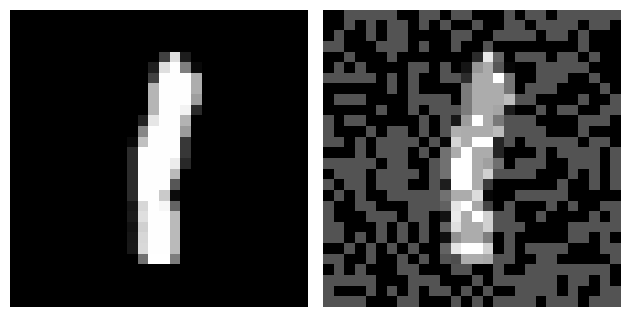

L-infinite norm of the difference: 0.24
1/1 [==============================] - 0s 152ms/step
True Label: 1 Predicted Label: 8


In [15]:
figg, axx = plt.subplots(1,2)
plt.gray()
axx[0].imshow(random_correctly_predicted_inputs[100])
axx[0].axis('off')
axx[1].imshow(results_fwb1[100][0])
axx[1].axis('off')
plt.tight_layout()
plt.show()

# Calculate the L-infinite norm of the difference matrix
print("L-infinite norm of the difference: {}".format(np.max(np.abs((results_fwb1[100][0]) - (random_correctly_predicted_inputs[100])))))
sample=np.expand_dims(results_fwb1[100][0], axis=-1)
sample=np.expand_dims(sample, axis=0)
label = np.expand_dims(true_labels[100], axis=0)
print("True Label: {} Predicted Label: {}".format(np.argmax(true_labels[100]), np.argmax(model.predict(sample))))

In [16]:
#Gaussian distribution
gg = np.arange(1000)
d = 28
T = 10
epsilon = 0.3
y_step = 0.8
b = 25
sigma = 0.01
beta = 0.99
opt = 2
rgb=0
start_time = time.process_time()
results_fwb2 = [frank_wolfe_bb(random_correctly_predicted_inputs[i],err_labels[i], d,T,epsilon,y_step,b,sigma,beta,opt,rgb) for i in gg]
end_time = time.process_time()
elapsed_time_fwb2 = end_time - start_time

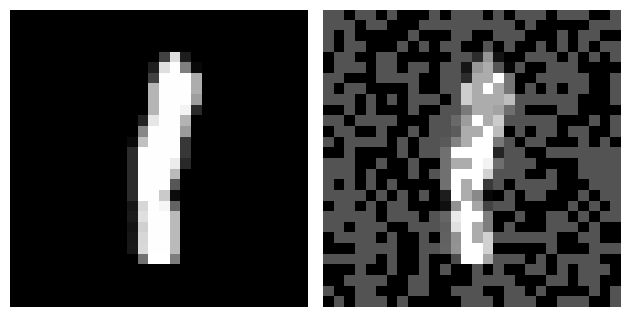

L-infinite norm of the difference: 0.24
1/1 [==============================] - 0s 31ms/step
True Label: 1 Predicted Label: 8


In [17]:
figg, axx = plt.subplots(1,2)
plt.gray()
axx[0].imshow(random_correctly_predicted_inputs[100])
axx[0].axis('off')
axx[1].imshow(results_fwb2[100][0])
axx[1].axis('off')
plt.tight_layout()
plt.show()

# Calculate the L-infinite norm of the difference matrix
print("L-infinite norm of the difference: {}".format(np.max(np.abs((results_fwb2[100][0]) - (random_correctly_predicted_inputs[100])))))
sample=np.expand_dims(results_fwb2[100][0], axis=-1)
sample=np.expand_dims(sample, axis=0)
label = np.expand_dims(true_labels[100], axis=0)
print("True Label: {} Predicted Label: {}".format(np.argmax(true_labels[100]), np.argmax(model.predict(sample))))

In [18]:
#Obtain a list of tuples (iteration T, accuracy at iteration T, L-infinite norm of distance at iteration T)
finals_fwb1=[]
finals_fwb1.append([0,model.evaluate(test_data,test_labels)[1],0.0,0.0]) #at first the accuracy is 99% and the L-infinite norm of distance is 0
for i in range(T): #for each iteration calculate the accuracy and L-infinite norm of distance of the obtained modified matrices of that iteration
  matrices=[inner_list[i] for inner_list in results_fwb1]
  tl = np.expand_dims(true_labels[:1000], axis=-1)
  td=np.expand_dims(matrices, axis=-1)
  finals_fwb1.append([i+1,model.evaluate(td,tl)[1],np.max((matrices)-(random_correctly_predicted_inputs[:1000])),np.abs(np.mean((matrices)-(random_correctly_predicted_inputs[:1000])))])

finals_fwb2=[]
finals_fwb2.append([0,1.0,0.0,0.0])
for i in range(T):
  matrices=[inner_list[i] for inner_list in results_fwb2]
  tl = np.expand_dims(true_labels[:1000], axis=-1)
  td=np.expand_dims(matrices, axis=-1)
  finals_fwb2.append([i+1,model.evaluate(td,tl)[1],np.max((matrices)-(random_correctly_predicted_inputs[:1000])),np.abs(np.mean((matrices)-(random_correctly_predicted_inputs[:1000])))])

32/32 [==============================] - 0s 4ms/step - loss: 0.7351 - accuracy: 0.7680


# Mnist Acc-SZOFW

In [20]:
#finite-sum
gg=np.arange(1000)
d=28
T=10
epsilon = 0.3
q=20
b=1
b1=300
b2=20
n=1
mi=0.01
eta=1/math.sqrt(T)
beta=(1/d)*(1/math.sqrt(T))
fs_setting=1
setting2=1
rgb=0
start_time = time.process_time()
results_acc_fs = [acc_szofw(random_correctly_predicted_inputs[i],err_labels[i],d, T,epsilon,q,b,b1,b2, n, mi,eta,beta, fs_setting, setting2,rgb) for i in gg]
end_time = time.process_time()
elapsed_time_acc_fs = end_time - start_time

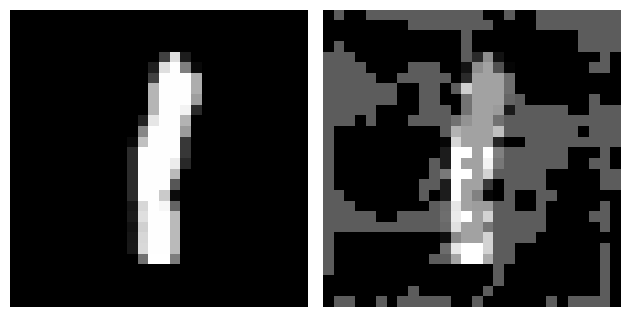

L-infinite norm of the difference: 0.2846049894151541
1/1 [==============================] - 0s 27ms/step
True Label: 1 Predicted Label: 8


In [21]:
figg, axx = plt.subplots(1,2)
plt.gray()
axx[0].imshow(random_correctly_predicted_inputs[100])
axx[0].axis('off')
axx[1].imshow(results_acc_fs[100][0])
axx[1].axis('off')
plt.tight_layout()
plt.show()

# Calculate the L-infinite norm of the difference matrix
print("L-infinite norm of the difference: {}".format(np.max(np.abs((results_acc_fs[100][0]) - (random_correctly_predicted_inputs[100])))))
sample=np.expand_dims(results_acc_fs[100][0], axis=-1)
sample=np.expand_dims(sample, axis=0)
label = np.expand_dims(true_labels[100], axis=0)
print("True Label: {} Predicted Label: {}".format(np.argmax(true_labels[100]), np.argmax(model.predict(sample))))

In [22]:
#stochastic setting Cooge
gg=np.arange(1000)
d=28
T=10
epsilon = 0.3
q=20
b=1
b1=300
b2=20
n=1
mi=0.01
eta=1/math.sqrt(T)
beta=(1/d)*(1/math.sqrt(T))
fs_setting=2
setting2=1
rgb=0
start_time = time.process_time()
results_acc_ss1 = [acc_szofw(random_correctly_predicted_inputs[i],err_labels[i],d, T,epsilon,q,b,b1,b2, n, mi,eta,beta, fs_setting, setting2,rgb) for i in gg]
end_time = time.process_time()
elapsed_time_acc_ss1 = end_time - start_time

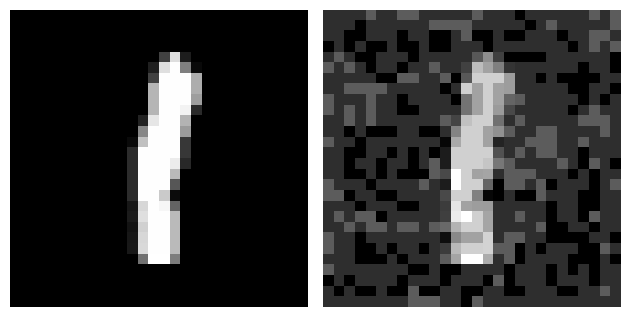

L-infinite norm of the difference: 0.2846049894151541
1/1 [==============================] - 0s 31ms/step
True Label: 1 Predicted Label: 8


In [23]:
figg, axx = plt.subplots(1,2)
plt.gray()
axx[0].imshow(random_correctly_predicted_inputs[100])
axx[0].axis('off')
axx[1].imshow(results_acc_ss1[100][0])
axx[1].axis('off')
plt.tight_layout()
plt.show()

# Calculate the L-infinite norm of the difference matrix
print("L-infinite norm of the difference: {}".format(np.max(np.abs((results_acc_ss1[100][0]) - (random_correctly_predicted_inputs[100])))))
sample=np.expand_dims(results_acc_ss1[100][0], axis=-1)
sample=np.expand_dims(sample, axis=0)
label = np.expand_dims(true_labels[100], axis=0)
print("True Label: {} Predicted Label: {}".format(np.argmax(true_labels[100]), np.argmax(model.predict(sample))))

In [24]:
#stochastic setting Unige
gg=np.arange(1000)
d=28
T=10
epsilon = 0.3
q=20
b=1
b1=300
b2=20
n=1
mi=0.01
eta=1/math.sqrt(T)
beta=(1/d)*(1/math.sqrt(T))
fs_setting=2
setting2=2
rgb=0
start_time = time.process_time()
results_acc_ss2 = [acc_szofw(random_correctly_predicted_inputs[i],err_labels[i],d, T,epsilon,q,b,b1,b2, n, mi,eta,beta, fs_setting, setting2,rgb) for i in gg]
end_time = time.process_time()
elapsed_time_acc_ss2 = end_time - start_time

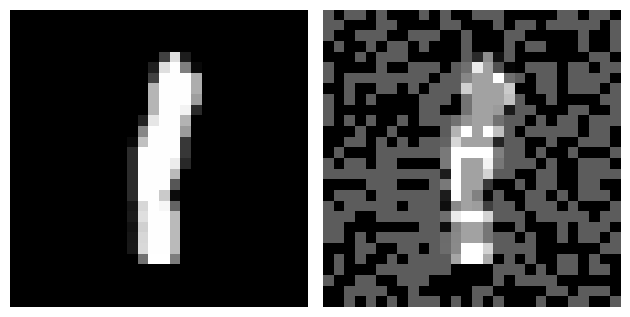

L-infinite norm of the difference: 0.2846049894151541
1/1 [==============================] - 0s 31ms/step
True Label: 1 Predicted Label: 8


In [25]:
figg, axx = plt.subplots(1,2)
plt.gray()
axx[0].imshow(random_correctly_predicted_inputs[100])
axx[0].axis('off')
axx[1].imshow(results_acc_ss2[100][0])
axx[1].axis('off')
plt.tight_layout()
plt.show()

# Calculate the L-infinite norm of the difference matrix
print("L-infinite norm of the difference: {}".format(np.max(np.abs((results_acc_ss2[100][0]) - (random_correctly_predicted_inputs[100])))))
sample=np.expand_dims(results_acc_ss2[100][0], axis=-1)
sample=np.expand_dims(sample, axis=0)
label = np.expand_dims(true_labels[100], axis=0)
print("True Label: {} Predicted Label: {}".format(np.argmax(true_labels[100]), np.argmax(model.predict(sample))))

In [26]:
finals_acc_fs=[]
finals_acc_fs.append([0,model.evaluate(test_data,test_labels)[1],0.0,0.0])
for i in range(T):
  matrices=[inner_list[i] for inner_list in results_acc_fs]
  tl = np.expand_dims(true_labels[:1000], axis=-1)
  td=np.expand_dims(matrices, axis=-1)
  finals_acc_fs.append([i+1,model.evaluate(td,tl)[1],np.max((matrices)-(random_correctly_predicted_inputs[:1000])),np.abs(np.mean((matrices)-(random_correctly_predicted_inputs[:1000])))])

finals_acc_ss1=[]
finals_acc_ss1.append([0,model.evaluate(test_data,test_labels)[1],0.0,0.0])
for i in range(T):
  matrices=[inner_list[i] for inner_list in results_acc_ss1]
  tl = np.expand_dims(true_labels[:1000], axis=-1)
  td=np.expand_dims(matrices, axis=-1)
  finals_acc_ss1.append([i+1,model.evaluate(td,tl)[1],np.max((matrices)-(random_correctly_predicted_inputs[:1000])),np.abs(np.mean((matrices)-(random_correctly_predicted_inputs[:1000])))])

finals_acc_ss2=[]
finals_acc_ss2.append([0,model.evaluate(test_data,test_labels)[1],0.0,0.0])
for i in range(T):
  matrices=[inner_list[i] for inner_list in results_acc_ss2]
  tl = np.expand_dims(true_labels[:1000], axis=-1)
  td=np.expand_dims(matrices, axis=-1)
  finals_acc_ss2.append([i+1,model.evaluate(td,tl)[1],np.max((matrices)-(random_correctly_predicted_inputs[:1000])),np.abs(np.mean((matrices)-(random_correctly_predicted_inputs[:1000])))])

32/32 [==============================] - 0s 4ms/step - loss: 2.7677 - accuracy: 0.3570


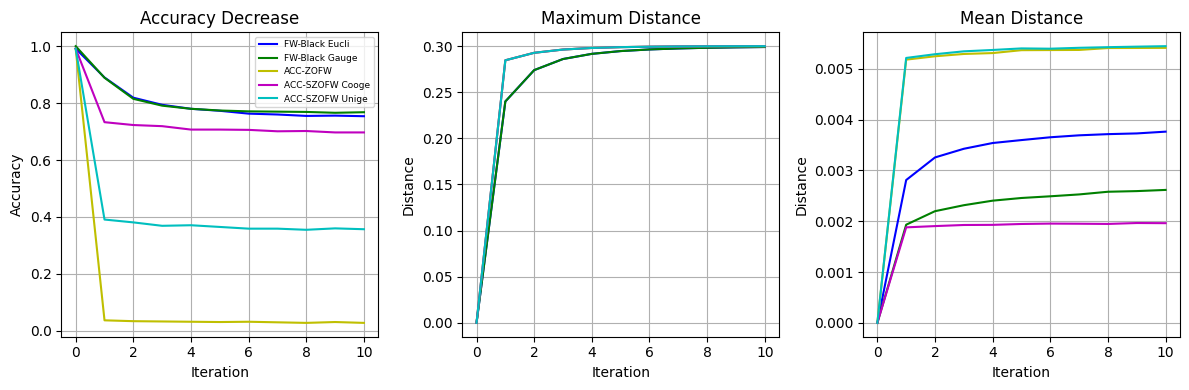

In [29]:
iter = [item[0] for item in finals_fwb1]
fwb1_values = [item[1] for item in finals_fwb1]
fwb2_values = [item[1] for item in finals_fwb2]
acc_fs_values = [item[1] for item in finals_acc_fs]
acc_ss1_values = [item[1] for item in finals_acc_ss1]
acc_ss2_values = [item[1] for item in finals_acc_ss2]

fwb1_d = [item[2] for item in finals_fwb1]
fwb2_d = [item[2] for item in finals_fwb2]
acc_fs_d = [item[2] for item in finals_acc_fs]
acc_ss1_d = [item[2] for item in finals_acc_ss1]
acc_ss2_d = [item[2] for item in finals_acc_ss2]

fwb1_dd = [item[3] for item in finals_fwb1]
fwb2_dd = [item[3] for item in finals_fwb2]
acc_fs_dd = [item[3] for item in finals_acc_fs]
acc_ss1_dd = [item[3] for item in finals_acc_ss1]
acc_ss2_dd = [item[3] for item in finals_acc_ss2]

# Creating subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
# Plotting first subplot
ax1.plot(iter, fwb1_values, linestyle='-', color='b',label='FW-Black Eucli')
ax1.plot(iter, fwb2_values, linestyle='-', color='g',label='FW-Black Gauge')
ax1.plot(iter, acc_fs_values, linestyle='-', color='y',label='ACC-ZOFW')
ax1.plot(iter, acc_ss1_values, linestyle='-', color='m',label='ACC-SZOFW Cooge')
ax1.plot(iter, acc_ss2_values, linestyle='-', color='c',label='ACC-SZOFW Unige')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy Decrease')
ax1.grid(True)
ax1.legend(loc='upper right',fontsize=6.5)

# Plotting second subplot
ax2.plot(iter, fwb1_d,  linestyle='-', color='b')
ax2.plot(iter, fwb2_d,  linestyle='-', color='g')
ax2.plot(iter, acc_fs_d,  linestyle='-', color='y')
ax2.plot(iter, acc_ss1_d,  linestyle='-', color='m')
ax2.plot(iter, acc_ss2_d,  linestyle='-', color='c')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Distance')
ax2.set_title('Maximum Distance')
ax2.grid(True)

# Plotting third subplot
ax3.plot(iter, fwb1_dd,  linestyle='-', color='b')
ax3.plot(iter, fwb2_dd,  linestyle='-', color='g')
ax3.plot(iter, acc_fs_dd,  linestyle='-', color='y')
ax3.plot(iter, acc_ss1_dd,  linestyle='-', color='m')
ax3.plot(iter, acc_ss2_dd,  linestyle='-', color='c')
ax3.set_xlabel('Iteration')
ax3.set_ylabel('Distance')
ax3.set_title('Mean Distance')
ax3.grid(True)

# Adjusting layout and showing the plots
plt.tight_layout()
plt.show()

In [28]:
print("FWBB Euclidean - Final Accuracy: {} - Mean Distance: {} - Max Distance: {} - Time: {}".format(fwb1_values[-1],fwb1_dd[-1],fwb1_d[-1],elapsed_time_fwb1))
print("FWBB Gaussian - Final Accuracy: {} - Mean Distance: {} - Max Distance: {} - Time: {}".format(fwb2_values[-1],fwb2_dd[-1],fwb2_d[-1],elapsed_time_fwb2))
print("AccZOFW FS - Final Accuracy: {} - Mean Distance: {} - Max Distance: {} - Time: {}".format(acc_fs_values[-1],acc_fs_dd[-1],acc_fs_d[-1],elapsed_time_acc_fs))
print("AccSZOFW Cooge - Final Accuracy: {} - Mean Distance: {} - Max Distance: {} - Time: {}".format(acc_ss1_values[-1],acc_ss1_dd[-1],acc_ss1_d[-1],elapsed_time_acc_ss1))
print("AccSZOFW Unige - Final Accuracy: {} - Mean Distance: {} - Max Distance: {} - Time: {}".format(acc_ss2_values[-1],acc_ss2_dd[-1],acc_ss2_d[-1],elapsed_time_acc_ss2))

FWBB Euclidean - Final Accuracy: 0.7540000081062317 - Mean Distance: 0.003762072422885018 - Max Distance: 0.29900271151407476 - Time: 187.350802525
FWBB Gaussian - Final Accuracy: 0.7680000066757202 - Mean Distance: 0.002615721843935429 - Max Distance: 0.29900271151407476 - Time: 186.42590001999997
AccZOFW FS - Final Accuracy: 0.02800000086426735 - Mean Distance: 0.005410238804836798 - Max Distance: 0.29991266695655017 - Time: 507.424586736
AccSZOFW Cooge - Final Accuracy: 0.6970000267028809 - Mean Distance: 0.0019616788844740323 - Max Distance: 0.29991266695655017 - Time: 510.5133917589999
AccSZOFW Unige - Final Accuracy: 0.3569999933242798 - Mean Distance: 0.0054437827871345445 - Max Distance: 0.29991266695655017 - Time: 324.2159805419999


# Cifar10 Dataset and Model

170498071/170498071 [==============================] - 4s 0us/step


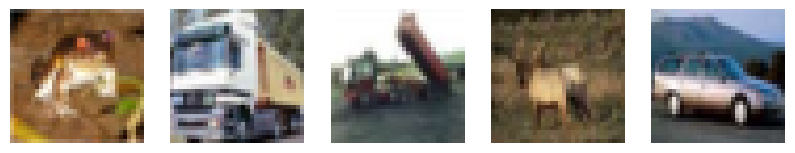

In [30]:
import tensorflow as tf
import cv2
# Load CIFAR-10 dataset
(train_data_or, train_labels_or), (test_data_or, test_labels_or) = tf.keras.datasets.cifar10.load_data()

##x_train_gray = []
##for img in train_data_or:
#    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
 #   x_train_gray.append(gray_img)
#x_train_gray = np.array(x_train_gray)
#x_test_gray = []
#for img in test_data_or:
#    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#    x_test_gray.append(gray_img)
#x_test_gray = np.array(x_test_gray)
plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(train_data_or[i], cmap='gray')
    plt.axis('off')
plt.show()

train_data = train_data_or.astype('float32') / 255.0 #Normalize pixels in range [0, 1]
test_data = test_data_or.astype('float32') / 255.0
train_data = np.expand_dims(train_data, axis=-1) #Expand the shape
test_data = np.expand_dims(test_data, axis=-1)
num_classes = 10 #from each label get an array e.g. label=5 -> [0,0,0,0,0,1,0,0,0,0]
train_labels = to_categorical(train_labels_or, num_classes)
test_labels = to_categorical(test_labels_or, num_classes)

In [31]:
#Create a model as described in the papers (6 layers CNN with 4 convolutional layers followed by 2 dense layers with max-pooling and Relu activations)
model = Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3), padding='same'))# First Convolutional Layer
model.add(MaxPool2D(2,2))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))# Second Convolutional Layer
model.add(MaxPool2D(2,2))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))# Third Convolutional Layer
model.add(MaxPool2D(2,2))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))# Fourth Convolutional Layer
model.add(MaxPool2D(2,2))
model.add(layers.Flatten())# Flatten the output for the Dense layers
model.add(layers.Dense(512, activation='relu'))# First Dense Layer
model.add(layers.Dense(256, activation='relu'))# Second Dense Layer
model.add(layers.Dense(num_classes, activation='softmax'))#Output layer
# Compile the model, use categorical cross entropy since we have multiple labels
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [32]:
model.fit(train_data, train_labels, epochs=20, batch_size=1000, validation_split=0.2)#train model on Mnist using validation set
model.evaluate(test_data,test_labels) #Evaluate the trained model on test set and get accuracy

Epoch 1/20
40/40 [==============================] - 6s 52ms/step - loss: 1.9762 - accuracy: 0.2645 - val_loss: 1.6851 - val_accuracy: 0.3842
Epoch 2/20
40/40 [==============================] - 2s 41ms/step - loss: 1.5847 - accuracy: 0.4204 - val_loss: 1.4832 - val_accuracy: 0.4651
Epoch 3/20
40/40 [==============================] - 2s 47ms/step - loss: 1.4141 - accuracy: 0.4846 - val_loss: 1.3355 - val_accuracy: 0.5114
Epoch 4/20
40/40 [==============================] - 2s 42ms/step - loss: 1.2880 - accuracy: 0.5334 - val_loss: 1.2278 - val_accuracy: 0.5574
Epoch 5/20
40/40 [==============================] - 2s 40ms/step - loss: 1.1982 - accuracy: 0.5691 - val_loss: 1.1620 - val_accuracy: 0.5868
Epoch 6/20
40/40 [==============================] - 2s 40ms/step - loss: 1.1055 - accuracy: 0.6070 - val_loss: 1.0899 - val_accuracy: 0.6092
Epoch 7/20
40/40 [==============================] - 2s 41ms/step - loss: 1.0371 - accuracy: 0.6314 - val_loss: 1.1014 - val_accuracy: 0.6006
Epoch 8/20
40

[0.9505248069763184, 0.708299994468689]

In [33]:
#get the indices of the correctly classified samples of the test set
predictions = model.predict(test_data)#get predictions
correctly_predicted_indices = np.argmax(predictions, axis=1) == np.argmax(test_labels, axis=1)#get indices of correct predictions
correctly_predicted_inputs = test_data_or[correctly_predicted_indices]#keep only pixels and labels of correct predictions
correctly_predicted_labels = np.argmax(test_labels[correctly_predicted_indices], axis=1)

# Randomly select 100 samples and generate a fake target class for each image
num_samples_to_select = 100
np.random.seed(42)
random_indices = np.random.choice(correctly_predicted_inputs.shape[0], num_samples_to_select, replace=False)#get random indices

random_correctly_predicted_inputs = correctly_predicted_inputs[random_indices]#get 1000 of the correctly predicted samples

#x_train_gray = []
#for img in random_correctly_predicted_inputs:
#    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#    x_train_gray.append(gray_img)
#x_train_gray = np.array(x_train_gray)

random_correctly_predicted_inputs = random_correctly_predicted_inputs.astype('float32') / 255.0
random_correctly_predicted_labels = correctly_predicted_labels[random_indices] #get the corresponding true labels
random_errate_predicted_labels=np.random.randint(9, size=len(random_correctly_predicted_labels))#generate 1000 fake target labels in [0,9]
#while we still have some fake labels equal to the true labels (because of random sampling) for these samples generate new fake labels
while(np.sum(random_errate_predicted_labels==random_correctly_predicted_labels)):
    random_errate_predicted_labels[np.where(random_correctly_predicted_labels==random_errate_predicted_labels)[0]]=np.random.randint(9)

true_labels = to_categorical(random_correctly_predicted_labels, num_classes)
err_labels = to_categorical(random_errate_predicted_labels, num_classes)

313/313 [==============================] - 1s 2ms/step


# Cifar10 FWBB

In [34]:
#euclidean sphere
gg = np.arange(100)
d = 32
T = 10
epsilon = 0.1
y_step = 0.8
b = 25
sigma = 0.01
beta = 0.99
opt = 1
rgb=1
start_time = time.process_time()
results_fwb1 = [frank_wolfe_bb(random_correctly_predicted_inputs[i],err_labels[i], d,T,epsilon,y_step,b,sigma,beta,opt,rgb) for i in gg]
end_time = time.process_time()
elapsed_time_fwb1 = end_time - start_time

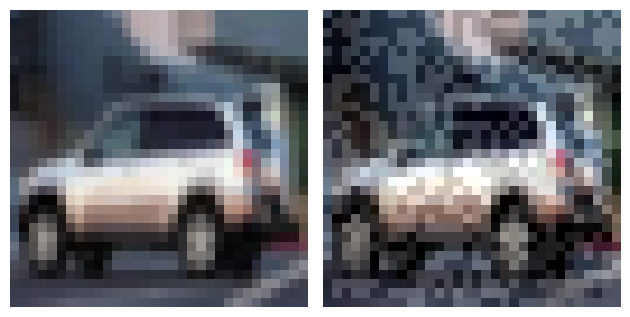

L-infinite norm of the difference: 0.08000000000000007
1/1 [==============================] - 0s 154ms/step
True Label: 1 Predicted Label: 9


In [35]:
figg, axx = plt.subplots(1,2)
plt.gray()
axx[0].imshow(random_correctly_predicted_inputs[0])
axx[0].axis('off')
axx[1].imshow(results_fwb1[0][0])
axx[1].axis('off')
plt.tight_layout()
plt.show()
print("L-infinite norm of the difference: {}".format(np.max(np.abs((results_fwb1[0][0]) - (random_correctly_predicted_inputs[0])))))
sample=np.expand_dims(results_fwb1[0][0], axis=-1)
sample=np.expand_dims(sample, axis=0)
label = np.expand_dims(true_labels[0], axis=0)
print("True Label: {} Predicted Label: {}".format(np.argmax(true_labels[0]), np.argmax(model.predict(sample))))

In [36]:
#Gaussian distribution
gg = np.arange(100)
d = 32
T = 10
epsilon = 0.1
y_step = 0.8
b = 25
sigma = 0.01
beta = 0.99
opt = 2
rgb=1
start_time = time.process_time()
results_fwb2 = [frank_wolfe_bb(random_correctly_predicted_inputs[i],err_labels[i], d,T,epsilon,y_step,b,sigma,beta,opt,rgb) for i in gg]
end_time = time.process_time()
elapsed_time_fwb2 = end_time - start_time

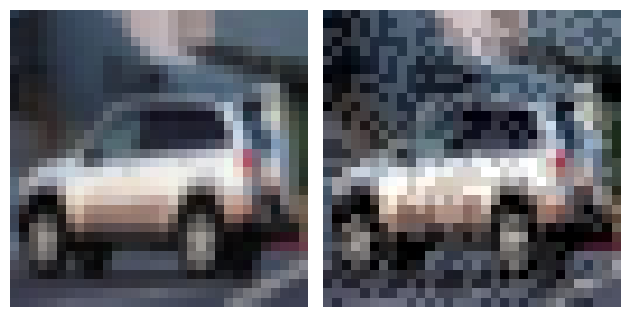

L-infinite norm of the difference: 0.08000000000000007
1/1 [==============================] - 0s 27ms/step
True Label: 1 Predicted Label: 9


In [37]:
figg, axx = plt.subplots(1,2)
plt.gray()
axx[0].imshow(random_correctly_predicted_inputs[0])
axx[0].axis('off')
axx[1].imshow(results_fwb2[0][0])
axx[1].axis('off')
plt.tight_layout()
plt.show()
print("L-infinite norm of the difference: {}".format(np.max(np.abs((results_fwb2[0][0]) - (random_correctly_predicted_inputs[0])))))
sample=np.expand_dims(results_fwb2[0][0], axis=-1)
sample=np.expand_dims(sample, axis=0)
label = np.expand_dims(true_labels[0], axis=0)
print("True Label: {} Predicted Label: {}".format(np.argmax(true_labels[0]), np.argmax(model.predict(sample))))

In [38]:
#Obtain a list of tuples (iteration T, accuracy at iteration T, L-infinite norm of distance at iteration T)
finals_fwb1=[]
finals_fwb1.append([0,model.evaluate(test_data,test_labels)[1],0.0,0,0])
for i in range(T): #for each iteration calculate the accuracy and L-infinite norm of distance of the obtained modified matrices of that iteration
  matrices=[inner_list[i] for inner_list in results_fwb1]
  tl = np.expand_dims(true_labels[:1000], axis=-1)
  td=np.expand_dims(matrices, axis=-1)
  finals_fwb1.append([i+1,model.evaluate(td,tl)[1],np.max((matrices)-(random_correctly_predicted_inputs[:1000])),np.abs(np.mean((matrices)-(random_correctly_predicted_inputs[:1000])))])

finals_fwb2=[]
finals_fwb2.append([0,model.evaluate(test_data,test_labels)[1],0.0,0,0])
for i in range(T):
  matrices=[inner_list[i] for inner_list in results_fwb2]
  tl = np.expand_dims(true_labels[:1000], axis=-1)
  td=np.expand_dims(matrices, axis=-1)
  finals_fwb2.append([i+1,model.evaluate(td,tl)[1],np.max((matrices)-(random_correctly_predicted_inputs[:1000])),np.abs(np.mean((matrices)-(random_correctly_predicted_inputs[:1000])))])

4/4 [==============================] - 0s 5ms/step - loss: 4.5704 - accuracy: 0.2300


# Cifar10 Acc-SZ0FW

In [39]:
gg=np.arange(100)
d=32
T=10
epsilon=0.1
q=20
b=1
b1=300
b2=20
n=1
mi=0.01
eta=1/math.sqrt(T)
beta=(1/d)*(1/math.sqrt(T))
fs_setting=1
setting2=1
rgb=1
start_time = time.process_time()
results_acc_fs = [acc_szofw(random_correctly_predicted_inputs[i],err_labels[i],d, T,epsilon,q,b,b1,b2, n, mi,eta,beta, fs_setting, setting2,rgb) for i in gg]
end_time = time.process_time()
elapsed_time_acc_fs = end_time - start_time

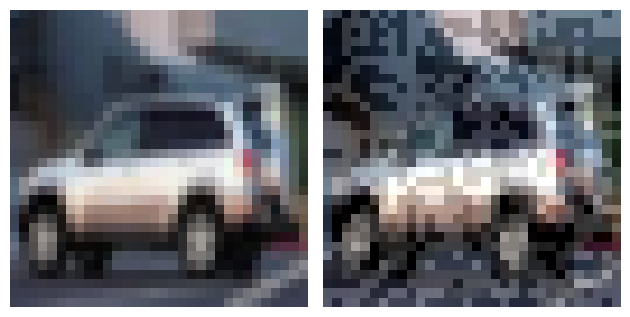

L-infinite norm of the difference: 0.09486832980505144
1/1 [==============================] - 0s 58ms/step
True Label: 1 Predicted Label: 9


In [40]:
figg, axx = plt.subplots(1,2)
plt.gray()
axx[0].imshow(random_correctly_predicted_inputs[0])
axx[0].axis('off')
axx[1].imshow(results_acc_fs[0][0])
axx[1].axis('off')
plt.tight_layout()
plt.show()
print("L-infinite norm of the difference: {}".format(np.max(np.abs((results_acc_fs[0][0]) - (random_correctly_predicted_inputs[0])))))
sample=np.expand_dims(results_acc_fs[0][0], axis=-1)
sample=np.expand_dims(sample, axis=0)
label = np.expand_dims(true_labels[0], axis=0)
print("True Label: {} Predicted Label: {}".format(np.argmax(true_labels[0]), np.argmax(model.predict(sample))))

In [41]:
gg=np.arange(100)
d=32
T=10
epsilon = 0.1
q=20
b=1
b1=300
b2=20
n=1
mi=0.01
eta=1/math.sqrt(T)
beta=(1/d)*(1/math.sqrt(T))
fs_setting=2
setting2=1
rgb=1
start_time = time.process_time()
results_acc_ss1 = [acc_szofw(random_correctly_predicted_inputs[i],err_labels[i],d, T,epsilon,q,b,b1,b2, n, mi,eta,beta, fs_setting, setting2,rgb) for i in gg]
end_time = time.process_time()
elapsed_time_acc_ss1 = end_time - start_time

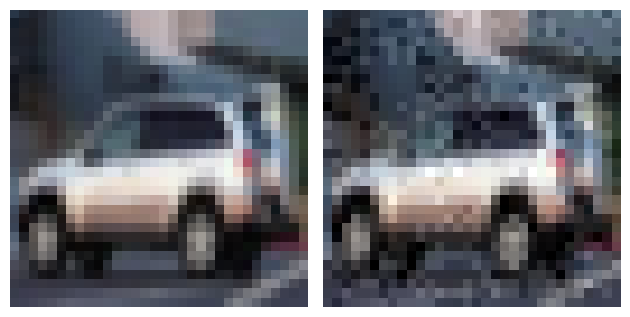

L-infinite norm of the difference: 0.09486832980505144
1/1 [==============================] - 0s 33ms/step
True Label: 1 Predicted Label: 9


In [42]:
figg, axx = plt.subplots(1,2)
plt.gray()
axx[0].imshow(random_correctly_predicted_inputs[0])
axx[0].axis('off')
axx[1].imshow(results_acc_ss1[0][0])
axx[1].axis('off')
plt.tight_layout()
plt.show()
print("L-infinite norm of the difference: {}".format(np.max(np.abs((results_acc_ss1[0][0]) - (random_correctly_predicted_inputs[0])))))
sample=np.expand_dims(results_acc_ss1[0][0], axis=-1)
sample=np.expand_dims(sample, axis=0)
label = np.expand_dims(true_labels[0], axis=0)
print("True Label: {} Predicted Label: {}".format(np.argmax(true_labels[0]), np.argmax(model.predict(sample))))

In [43]:
gg=np.arange(100)
d=32
T=10
epsilon = 0.1
q=20
b=1
b1=300
b2=20
n=1
mi=0.01
eta=1/math.sqrt(T)
beta=(1/d)*(1/math.sqrt(T))
fs_setting=2
setting2=2
rgb=1
start_time = time.process_time()
results_acc_ss2 = [acc_szofw(random_correctly_predicted_inputs[i],err_labels[i],d, T,epsilon,q,b,b1,b2, n, mi,eta,beta, fs_setting, setting2,rgb) for i in gg]
end_time = time.process_time()
elapsed_time_acc_ss2 = end_time - start_time

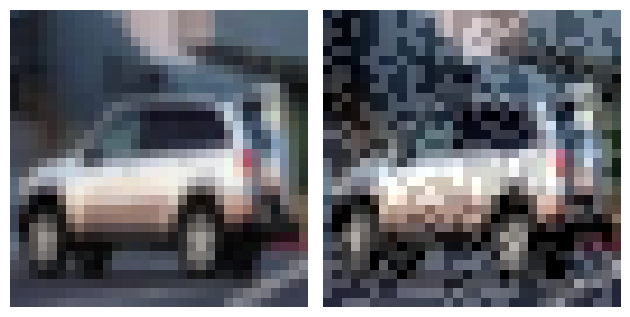

L-infinite norm of the difference: 0.09486832980505144
1/1 [==============================] - 0s 38ms/step
True Label: 1 Predicted Label: 9


In [44]:
figg, axx = plt.subplots(1,2)
plt.gray()
axx[0].imshow(random_correctly_predicted_inputs[0])
axx[0].axis('off')
axx[1].imshow(results_acc_ss2[0][0])
axx[1].axis('off')
plt.tight_layout()
plt.show()
print("L-infinite norm of the difference: {}".format(np.max(np.abs((results_acc_ss2[0][0]) - (random_correctly_predicted_inputs[0])))))
sample=np.expand_dims(results_acc_ss2[0][0], axis=-1)
sample=np.expand_dims(sample, axis=0)
label = np.expand_dims(true_labels[0], axis=0)
print("True Label: {} Predicted Label: {}".format(np.argmax(true_labels[0]), np.argmax(model.predict(sample))))

In [45]:
finals_acc_fs=[]
finals_acc_fs.append([0,model.evaluate(test_data,test_labels)[1],0.0,0,0])
for i in range(T):
  matrices=[inner_list[i] for inner_list in results_acc_fs]
  tl = np.expand_dims(true_labels[:1000], axis=-1)
  td=np.expand_dims(matrices, axis=-1)
  finals_acc_fs.append([i+1,model.evaluate(td,tl)[1],np.max((matrices)-(random_correctly_predicted_inputs[:1000])),np.abs(np.mean((matrices)-(random_correctly_predicted_inputs[:1000])))])

finals_acc_ss1=[]
finals_acc_ss1.append([0,model.evaluate(test_data,test_labels)[1],0.0,0,0])
for i in range(T):
  matrices=[inner_list[i] for inner_list in results_acc_ss1]
  tl = np.expand_dims(true_labels[:1000], axis=-1)
  td=np.expand_dims(matrices, axis=-1)
  finals_acc_ss1.append([i+1,model.evaluate(td,tl)[1],np.max((matrices)-(random_correctly_predicted_inputs[:1000])),np.abs(np.mean((matrices)-(random_correctly_predicted_inputs[:1000])))])

finals_acc_ss2=[]
finals_acc_ss2.append([0,model.evaluate(test_data,test_labels)[1],0.0,0,0])
for i in range(T):
  matrices=[inner_list[i] for inner_list in results_acc_ss2]
  tl = np.expand_dims(true_labels[:1000], axis=-1)
  td=np.expand_dims(matrices, axis=-1)
  finals_acc_ss2.append([i+1,model.evaluate(td,tl)[1],np.max((matrices)-(random_correctly_predicted_inputs[:1000])),np.abs(np.mean((matrices)-(random_correctly_predicted_inputs[:1000])))])

4/4 [==============================] - 0s 5ms/step - loss: 6.6404 - accuracy: 0.1400


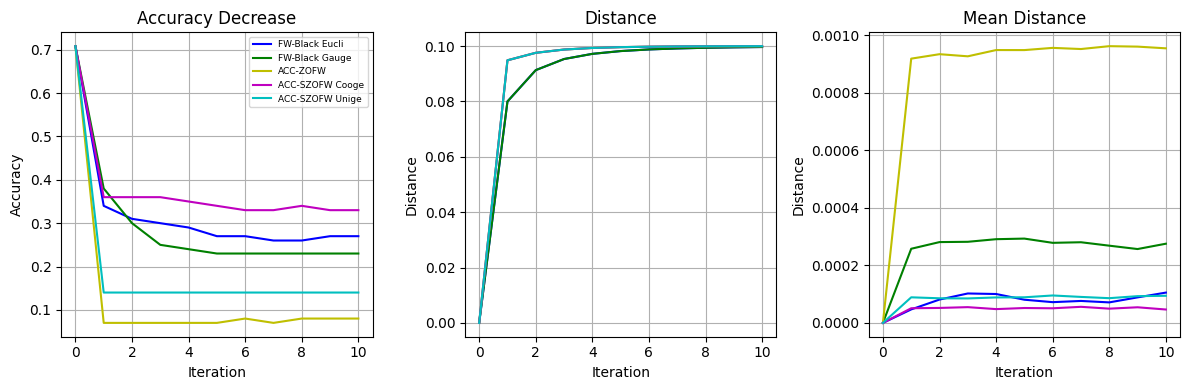

In [46]:
iter = [item[0] for item in finals_fwb1]
fwb1_values = [item[1] for item in finals_fwb1]
fwb2_values = [item[1] for item in finals_fwb2]
acc_fs_values = [item[1] for item in finals_acc_fs]
acc_ss1_values = [item[1] for item in finals_acc_ss1]
acc_ss2_values = [item[1] for item in finals_acc_ss2]

fwb1_d = [item[2] for item in finals_fwb1]
fwb2_d = [item[2] for item in finals_fwb2]
acc_fs_d = [item[2] for item in finals_acc_fs]
acc_ss1_d = [item[2] for item in finals_acc_ss1]
acc_ss2_d = [item[2] for item in finals_acc_ss2]

fwb1_dd = [item[3] for item in finals_fwb1]
fwb2_dd = [item[3] for item in finals_fwb2]
acc_fs_dd = [item[3] for item in finals_acc_fs]
acc_ss1_dd = [item[3] for item in finals_acc_ss1]
acc_ss2_dd = [item[3] for item in finals_acc_ss2]

# Creating subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
# Plotting first subplot
ax1.plot(iter, fwb1_values, linestyle='-', color='b',label='FW-Black Eucli')
ax1.plot(iter, fwb2_values, linestyle='-', color='g',label='FW-Black Gauge')
ax1.plot(iter, acc_fs_values, linestyle='-', color='y',label='ACC-ZOFW')
ax1.plot(iter, acc_ss1_values, linestyle='-', color='m',label='ACC-SZOFW Cooge')
ax1.plot(iter, acc_ss2_values, linestyle='-', color='c',label='ACC-SZOFW Unige')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy Decrease')
ax1.grid(True)
ax1.legend(loc='upper right',fontsize=6.5)

# Plotting second subplot
ax2.plot(iter, fwb1_d,  linestyle='-', color='b')
ax2.plot(iter, fwb2_d,  linestyle='-', color='g')
ax2.plot(iter, acc_fs_d,  linestyle='-', color='y')
ax2.plot(iter, acc_ss1_d,  linestyle='-', color='m')
ax2.plot(iter, acc_ss2_d,  linestyle='-', color='c')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Distance')
ax2.set_title('Distance')
ax2.grid(True)

# Plotting third subplot
ax3.plot(iter, fwb1_dd,  linestyle='-', color='b')
ax3.plot(iter, fwb2_dd,  linestyle='-', color='g')
ax3.plot(iter, acc_fs_dd,  linestyle='-', color='y')
ax3.plot(iter, acc_ss1_dd,  linestyle='-', color='m')
ax3.plot(iter, acc_ss2_dd,  linestyle='-', color='c')
ax3.set_xlabel('Iteration')
ax3.set_ylabel('Distance')
ax3.set_title('Mean Distance')
ax3.grid(True)

# Adjusting layout and showing the plots
plt.tight_layout()
plt.show()

In [47]:
print("FWBB Euclidean - Final Accuracy: {} - Mean Distance: {} - Max Distance: {} - Time: {}".format(fwb1_values[-1],fwb1_dd[-1],fwb1_d[-1],elapsed_time_fwb1))
print("FWBB Gaussian - Final Accuracy: {} - Mean Distance: {} - Max Distance: {} - Time: {}".format(fwb2_values[-1],fwb2_dd[-1],fwb2_d[-1],elapsed_time_fwb2))
print("AccZOFW FS - Final Accuracy: {} - Mean Distance: {} - Max Distance: {} - Time: {}".format(acc_fs_values[-1],acc_fs_dd[-1],acc_fs_d[-1],elapsed_time_acc_fs))
print("AccSZOFW Cooge - Final Accuracy: {} - Mean Distance: {} - Max Distance: {} - Time: {}".format(acc_ss1_values[-1],acc_ss1_dd[-1],acc_ss1_d[-1],elapsed_time_acc_ss1))
print("AccSZOFW Unige - Final Accuracy: {} - Mean Distance: {} - Max Distance: {} - Time: {}".format(acc_ss2_values[-1],acc_ss2_dd[-1],acc_ss2_d[-1],elapsed_time_acc_ss2))

FWBB Euclidean - Final Accuracy: 0.27000001072883606 - Mean Distance: 0.00010532346583406636 - Max Distance: 0.09966757050469166 - Time: 21.09766119699998
FWBB Gaussian - Final Accuracy: 0.23000000417232513 - Mean Distance: 0.00027535181939380835 - Max Distance: 0.09966757050469166 - Time: 19.935490543000014
AccZOFW FS - Final Accuracy: 0.07999999821186066 - Mean Distance: 0.0009549392422094124 - Max Distance: 0.09997088898551687 - Time: 187.04696864900006
AccSZOFW Cooge - Final Accuracy: 0.33000001311302185 - Mean Distance: 4.653025773728017e-05 - Max Distance: 0.09997088898551687 - Time: 215.79006648700033
AccSZOFW Unige - Final Accuracy: 0.14000000059604645 - Mean Distance: 9.424466545012855e-05 - Max Distance: 0.09997088898551687 - Time: 37.545501461000185
